In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
 ## imports 
import pandas as pd
import numpy as np
from itertools import product
from sklearn.utils import shuffle
np.random.seed(20)

In [0]:
all_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competitive data science/Final Project/all_data.csv.gz')
all_data.index = all_data.ID
all_data.head()

,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum,ID,shop_item_id
ID,,,,,,,,
12300,1,230,0,0.0,0.0,2.38532,12300,1230
12570,1,257,0,0.0,0.0,2.00000,12570,1257
12590,1,259,0,0.0,0.0,2.38532,12590,1259
12670,1,267,0,0.0,0.0,2.38532,12670,1267
12760,1,276,0,0.0,0.0,2.38532,12760,1276


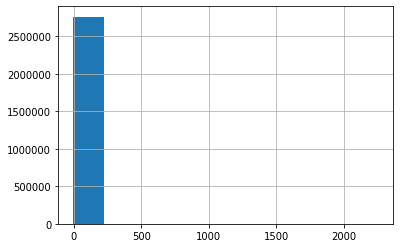

In [0]:
all_data['target'].hist()

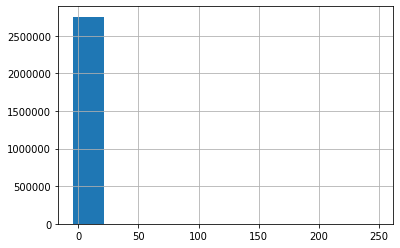

In [0]:
# seeing that distribution is so assymmetric, let's cut the range to see if maybe for smaller values it is more symmetric
all_data[all_data['target'] <= 250]['target'].hist()

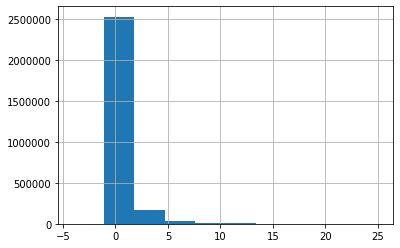

In [0]:
all_data[all_data['target'] <= 25]['target'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ef3b50ef0>,
      dtype=object)

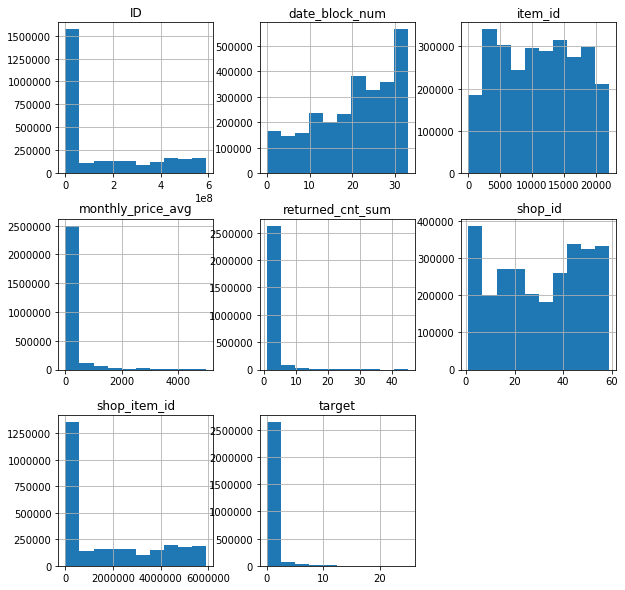

In [0]:
# resolution: clip to 25
all_data['target'] = all_data['target'].clip(0, 25)
all_data.hist(figsize=(10,10))

In [0]:
# id distribution is not uniform because it is a concatenation:
all_data['ID'].value_counts()

51513428     1
51117013     1
592159710    1
34323421     1
35708533     1
            ..
6998028      1
371912715    1
15398922     1
281506312    1
25165824     1
Name: ID, Length: 2760686, dtype: int64

In [0]:
all_data.dtypes

shop_id                int64
item_id                int64
date_block_num         int64
target               float64
monthly_price_avg    float64
returned_cnt_sum     float64
ID                     int64
shop_item_id           int64
dtype: object

In [0]:
# at least we can remove outliers by item, based on the inter-quantile-range heuristic
print('Shape prior to IQR heuristic is', all_data.shape)
all_data['Q1'] = all_data['item_id'].map(all_data.groupby('item_id').target.quantile(q=.25))
all_data['Q3'] = all_data['item_id'].map(all_data.groupby('item_id').target.quantile(q=.75))
all_data['IQR'] = all_data['Q3'] - all_data['Q1']
all_data['boxplot_max'] = all_data['Q3'] + 1.5 * all_data['IQR']
all_data['boxplot_min'] = all_data['Q1'] - 1.5 * all_data['IQR']
all_data = all_data[(all_data['target'] >= all_data['boxplot_min']) | (all_data['target'] <= all_data['boxplot_max'])]
print('Shape after heuristic is', all_data.shape)


Shape prior to IQR heuristic is (2760686, 8)
Shape after heuristic is (2760686, 13)


In [0]:
# conclusion, in the future try to separate only zero values.
# for now, generate more features.
############################ FEATURE ENGINEERING ####################################

In [0]:
# 1. Merge all dataframes: shop, item, category. In the meantime, create features too (every word position is a feat, let us see)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

shops = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/shops.csv')

def create_one_feat_per_word_in_str_column(df, colname):
  """
  Split the text col in a list of words, take len.
  Select max len, and then make a column for each position in that len. 
  If len of a word is as big as len, then insert empty string.
  Finally apply label encoder. 
  """
  df[f'{colname}_len'] = df[colname].apply(lambda x: len(x.split(' ')))
  for i in range(df[f'{colname}_len'].max()):
    df[f'{colname}_word_{i}'] = df[colname].apply(lambda x: x.split(' ')[i] if len(x.split(' ')) > i else ' ')
    df[f'{colname}_word_{i}'] = le.fit_transform(df[f'{colname}_word_{i}'])
  
  return df

shops  = create_one_feat_per_word_in_str_column(shops, 'shop_name')

shops.head()


,shop_name,shop_id,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5
0,"!Якутск Орджоникидзе, 56 фран",0,4,0,4,41,21,0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,4,0,9,38,21,0,0
2,"Адыгея ТЦ ""Мега""",2,3,1,9,21,0,0,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,3,2,7,26,0,0,0
4,"Волжский ТЦ ""Волга Молл""",4,4,3,9,10,15,0,0


In [0]:
all_data = pd.merge(all_data, shops, how='left', on='shop_id')
del shops
all_data.head()

,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum,ID,shop_item_id,Q1,Q3,IQR,boxplot_max,boxplot_min,shop_name,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5
0,1,230,0,0.0,0.0,2.38532,12300,1230,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0
1,1,257,0,0.0,0.0,2.00000,12570,1257,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0
2,1,259,0,0.0,0.0,2.38532,12590,1259,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0
3,1,267,0,0.0,0.0,2.38532,12670,1267,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0
4,1,276,0,0.0,0.0,2.38532,12760,1276,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0


In [0]:
items = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [0]:
categories = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/item_categories.csv')
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [0]:
items = create_one_feat_per_word_in_str_column(items, 'item_name')
categories = create_one_feat_per_word_in_str_column(categories, 'item_category_name')

In [0]:
items = pd.merge(items, categories, on='item_category_id', how='left')
del categories
items.head()

,item_name,item_id,item_category_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_name_word_9,item_name_word_10,item_name_word_11,item_name_word_12,item_name_word_13,item_name_word_14,item_name_word_15,item_name_word_16,item_name_word_17,item_name_word_18,item_name_word_19,item_name_word_20,item_name_word_21,item_name_word_22,item_name_word_23,item_name_word_24,item_name_word_25,item_name_word_26,item_name_word_27,item_name_word_28,item_category_name,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,14,0,2107,2367,3663,222,0,0,0,0,0,0,0,0,88,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,9,1,820,299,1786,1064,1078,1480,1490,1134,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Программы - Для дома и офиса (Цифра),7,11,2,26,27,8,2,1
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,26,2,3149,4120,0,0,197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,26,3,2134,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0
4,***КОРОБКА (СТЕКЛО) D,4,40,25,4,142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0


In [0]:
######## LANGUAGE FEATURES ########
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return distance[row][col]

items['levenshtein_dist'] = items[['item_category_name', 'item_name']].apply(lambda x: levenshtein_ratio_and_distance(x[0], x[1]), axis=1)
items['levenshtein_dist_ratio'] = items[['item_category_name', 'item_name']].apply(lambda x:
                                                                                   levenshtein_ratio_and_distance(x[0], x[1], ratio_calc=True), axis=1)
items.head()

,item_name,item_id,item_category_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_name_word_9,item_name_word_10,item_name_word_11,item_name_word_12,item_name_word_13,item_name_word_14,item_name_word_15,item_name_word_16,item_name_word_17,item_name_word_18,item_name_word_19,item_name_word_20,item_name_word_21,item_name_word_22,item_name_word_23,item_name_word_24,item_name_word_25,item_name_word_26,item_name_word_27,item_name_word_28,item_category_name,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,levenshtein_dist,levenshtein_dist_ratio
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,14,0,2107,2367,3663,222,0,0,0,0,0,0,0,0,88,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0,38,0.117647
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,9,1,820,299,1786,1064,1078,1480,1490,1134,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Программы - Для дома и офиса (Цифра),7,11,2,26,27,8,2,1,59,0.211538
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,26,2,3149,4120,0,0,197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0,41,0.145455
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,26,3,2134,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0,44,0.105263
4,***КОРОБКА (СТЕКЛО) D,4,40,25,4,142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,Кино - DVD,3,7,2,8,0,0,0,0,39,0.150943


In [0]:
all_data = pd.merge(all_data, items, on='item_id', how='left')
del items
all_data.head()

,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum,ID,shop_item_id,Q1,Q3,IQR,boxplot_max,boxplot_min,shop_name,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,item_name,item_category_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_name_word_9,item_name_word_10,item_name_word_11,item_name_word_12,item_name_word_13,item_name_word_14,item_name_word_15,item_name_word_16,item_name_word_17,item_name_word_18,item_name_word_19,item_name_word_20,item_name_word_21,item_name_word_22,item_name_word_23,item_name_word_24,item_name_word_25,item_name_word_26,item_name_word_27,item_name_word_28,item_category_name,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,levenshtein_dist,levenshtein_dist_ratio
0,1,230,0,0.0,0.0,2.38532,12300,1230,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Дефо Д. Робинзон Крузо,45,5,50,2545,2577,4163,2795,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,28,0.379310
1,1,257,0,0.0,0.0,2.00000,12570,1257,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Карамзин Н.М. История государст...,45,11,50,3007,3479,3211,3791,2506,1843,1285,904,882,535,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,87,0.214876
2,1,259,0,0.0,0.0,2.38532,12590,1259,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Киплинг Р. Сказки и легенды (Di...,45,7,50,3021,3945,4330,3906,3079,116,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,43,0.324324
3,1,267,0,0.0,0.0,2.38532,12670,1267,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Коллекция русских народных сказ...,45,6,50,3039,5318,5227,4465,166,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,48,0.275000
4,1,276,0,0.0,0.0,2.38532,12760,1276,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Кун Н.А. Легенды и мифы древней...,45,9,50,3085,3477,3455,3906,3147,2258,1229,53,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,49,0.317073


In [0]:
# Now encodings
from sklearn.model_selection import KFold
gmean = 0.3343

# target mean and median
all_data['item_target_enc'] = all_data['item_id'].map(all_data.groupby('item_id').target.mean())
all_data['item_target_enc'].fillna(0.3343, inplace=True) 
all_data['item_Q2'] = all_data.groupby('item_id')['target'].transform('median')
all_data['item_Q2'].fillna(gmean, inplace=True)

#k fold encoding
skf = KFold(5, shuffle=False).split(all_data)
all_data['kfold_encoding'] = np.nan

for tr_ind, val_ind in skf: 
    X_tr, X_val  = all_data.iloc[tr_ind], all_data.iloc[val_ind]
    means = X_val['item_id'].map(X_tr.groupby('item_id')['target'].mean()).values
    all_data.iloc[val_ind, np.where(all_data.columns=='kfold_encoding')[0]] = means
all_data['kfold_encoding'].fillna(gmean, inplace=True)

# leave one-out encoding
tot_sum = all_data.groupby('item_id').sum()['target']
all_data['loo_encoding'] = all_data.groupby('item_id')['target'].transform('sum')
all_data['cnt_per_itemid'] = all_data.groupby('item_id')['target'].transform('count')
all_data['loo_encoding'] = (all_data['loo_encoding'] - all_data['target']) / all_data['cnt_per_itemid']
all_data['loo_encoding'].fillna(gmean, inplace=True) 

# smoothing encoding
a = 100
means_items = all_data['item_id'].map(all_data.groupby('item_id').mean()['target'])
counts_items = all_data['item_id'].map(all_data.groupby('item_id').count()['target'])
all_data['smoothing_enc'] =  (all_data['item_target_enc'].values * all_data['cnt_per_itemid'].values
                              + gmean * a)/(all_data['cnt_per_itemid'].values + a)
all_data['smoothing_enc'].fillna(gmean, inplace=True)

# expanding mean of target mean encoding
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcount = all_data.groupby('item_id').cumcount()
all_data['exp_mean_enc'] = cumsum / cumcount
all_data['exp_mean_enc'].fillna(all_data['exp_mean_enc'].mean(), inplace=True)

# add another one as it changes by permutations
cumsum = all_data.sample(frac=1, random_state=20).groupby('item_id')['target'].cumsum() - all_data['target']
cumcount = all_data.sample(frac=1, random_state=20).groupby('item_id').cumcount()
all_data['exp_mean_enc2'] = cumsum / cumcount
all_data['exp_mean_enc2'].fillna(all_data['exp_mean_enc2'].mean(), inplace=True)

all_data.head()





,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum,ID,shop_item_id,Q1,Q3,IQR,boxplot_max,boxplot_min,shop_name,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,item_name,item_category_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_name_word_9,item_name_word_10,item_name_word_11,item_name_word_12,item_name_word_13,item_name_word_14,item_name_word_15,item_name_word_16,item_name_word_17,item_name_word_18,item_name_word_19,item_name_word_20,item_name_word_21,item_name_word_22,item_name_word_23,item_name_word_24,item_name_word_25,item_name_word_26,item_name_word_27,item_name_word_28,item_category_name,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,levenshtein_dist,levenshtein_dist_ratio,item_target_enc,item_Q2,kfold_encoding,loo_encoding,cnt_per_itemid,smoothing_enc,exp_mean_enc,exp_mean_enc2
0,1,230,0,0.0,0.0,2.38532,12300,1230,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Дефо Д. Робинзон Крузо,45,5,50,2545,2577,4163,2795,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,28,0.379310,0.011905,0.0,0.032258,0.011905,168,0.132201,0.686244,0.013072
1,1,257,0,0.0,0.0,2.00000,12570,1257,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Карамзин Н.М. История государст...,45,11,50,3007,3479,3211,3791,2506,1843,1285,904,882,535,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,87,0.214876,0.058442,0.0,0.076923,0.058442,154,0.167047,0.686244,0.054945
2,1,259,0,0.0,0.0,2.38532,12590,1259,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Киплинг Р. Сказки и легенды (Di...,45,7,50,3021,3945,4330,3906,3079,116,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,43,0.324324,0.087901,0.0,0.065476,0.087901,967,0.110993,0.686244,0.092643
3,1,267,0,0.0,0.0,2.38532,12670,1267,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Коллекция русских народных сказ...,45,6,50,3039,5318,5227,4465,166,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,48,0.275000,0.011628,0.0,0.334300,0.011628,86,0.185108,0.686244,0.000000
4,1,276,0,0.0,0.0,2.38532,12760,1276,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Кун Н.А. Легенды и мифы древней...,45,9,50,3085,3477,3455,3906,3147,2258,1229,53,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,49,0.317073,0.097087,0.0,0.000000,0.097087,103,0.213941,0.686244,0.000000


In [0]:
all_data['ID'] = all_data['shop_id'].astype(str) + all_data['item_id'].astype(str) + all_data['date_block_num'].astype(str)
all_data.to_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/all_data.csv', index=False)

In [0]:
all_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/all_data.csv')
all_data.index = all_data.ID
all_data.head()

,shop_id,item_id,date_block_num,target,monthly_price_avg,returned_cnt_sum,ID,shop_item_id,Q1,Q3,IQR,boxplot_max,boxplot_min,shop_name,shop_name_len,shop_name_word_0,shop_name_word_1,shop_name_word_2,shop_name_word_3,shop_name_word_4,shop_name_word_5,item_name,item_category_id,item_name_len,item_name_word_0,item_name_word_1,item_name_word_2,item_name_word_3,item_name_word_4,item_name_word_5,item_name_word_6,item_name_word_7,item_name_word_8,item_name_word_9,item_name_word_10,item_name_word_11,item_name_word_12,item_name_word_13,item_name_word_14,item_name_word_15,item_name_word_16,item_name_word_17,item_name_word_18,item_name_word_19,item_name_word_20,item_name_word_21,item_name_word_22,item_name_word_23,item_name_word_24,item_name_word_25,item_name_word_26,item_name_word_27,item_name_word_28,item_category_name,item_category_name_len,item_category_name_word_0,item_category_name_word_1,item_category_name_word_2,item_category_name_word_3,item_category_name_word_4,item_category_name_word_5,item_category_name_word_6,levenshtein_dist,levenshtein_dist_ratio,item_target_enc,item_Q2,kfold_encoding,loo_encoding,cnt_per_itemid,smoothing_enc,exp_mean_enc,exp_mean_enc2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12300,1,230,0,0.0,0.0,2.38532,12300,1230,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Дефо Д. Робинзон Крузо,45,5,50,2545,2577,4163,2795,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,28,0.379310,0.011905,0.0,0.032258,0.011905,168,0.132201,0.686244,0.013072
12570,1,257,0,0.0,0.0,2.00000,12570,1257,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Карамзин Н.М. История государст...,45,11,50,3007,3479,3211,3791,2506,1843,1285,904,882,535,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,87,0.214876,0.058442,0.0,0.076923,0.058442,154,0.167047,0.686244,0.054945
12590,1,259,0,0.0,0.0,2.38532,12590,1259,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Киплинг Р. Сказки и легенды (Di...,45,7,50,3021,3945,4330,3906,3079,116,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,43,0.324324,0.087901,0.0,0.065476,0.087901,967,0.110993,0.686244,0.092643
12670,1,267,0,0.0,0.0,2.38532,12670,1267,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Коллекция русских народных сказ...,45,6,50,3039,5318,5227,4465,166,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,48,0.275000,0.011628,0.0,0.334300,0.011628,86,0.185108,0.686244,0.000000
12760,1,276,0,0.0,0.0,2.38532,12760,1276,0.0,0.0,0.0,0.0,0.0,"!Якутск ТЦ ""Центральный"" фран",4,0,9,38,21,0,0,1С:Аудиокниги. Кун Н.А. Легенды и мифы древней...,45,9,50,3085,3477,3455,3906,3147,2258,1229,53,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Книги - Аудиокниги 1С,4,8,2,20,3,0,0,0,49,0.317073,0.097087,0.0,0.000000,0.097087,103,0.213941,0.686244,0.000000


In [0]:
# check column names, to see what else can be engineered.
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'monthly_price_avg',
       'returned_cnt_sum', 'ID', 'shop_item_id', 'Q1', 'Q3', 'IQR',
       'boxplot_max', 'boxplot_min', 'shop_name', 'shop_name_len',
       'shop_name_word_0', 'shop_name_word_1', 'shop_name_word_2',
       'shop_name_word_3', 'shop_name_word_4', 'shop_name_word_5', 'item_name',
       'item_category_id', 'item_name_len', 'item_name_word_0',
       'item_name_word_1', 'item_name_word_2', 'item_name_word_3',
       'item_name_word_4', 'item_name_word_5', 'item_name_word_6',
       'item_name_word_7', 'item_name_word_8', 'item_name_word_9',
       'item_name_word_10', 'item_name_word_11', 'item_name_word_12',
       'item_name_word_13', 'item_name_word_14', 'item_name_word_15',
       'item_name_word_16', 'item_name_word_17', 'item_name_word_18',
       'item_name_word_19', 'item_name_word_20', 'item_name_word_21',
       'item_name_word_22', 'item_name_word_23', 'item_name_word_24',
       'item_name_word_25

In [0]:
all_data.corr()['target'].values

array([ 2.15186989e-02, -6.23447266e-02, -4.31701217e-02,  1.00000000e+00,
        4.25389799e-01,  2.76957841e-01, -3.99864611e-02, -3.91579692e-02,
        3.54049793e-01,  5.22355151e-01,  4.45544486e-01,  4.92319372e-01,
       -3.17986039e-01,  3.32383389e-02,  2.08204495e-02, -3.43629323e-02,
        3.86444664e-03,  1.86172316e-02,  6.44589966e-02,  6.36427063e-02,
       -1.03647343e-01,  1.12380822e-02, -6.29679419e-02, -1.79600117e-02,
        2.85908101e-02,  2.50217888e-02,  4.70719543e-02,  5.56673247e-02,
        3.17263885e-02,  2.66174961e-02,  2.17016323e-02,  8.79089944e-03,
        9.58581811e-03,  2.30792780e-03, -6.14512160e-03, -6.76565581e-03,
       -1.24054636e-03, -7.58775429e-03, -8.25899049e-03, -4.52537116e-03,
       -7.08884910e-04,  2.42870324e-03,  1.82361764e-03, -6.22255882e-04,
        7.90272621e-04,  2.15528102e-04,  6.30418551e-04, -6.30418551e-04,
                   nan,             nan,             nan,  4.04401452e-02,
       -1.10826691e-01,  

In [0]:
all_data['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

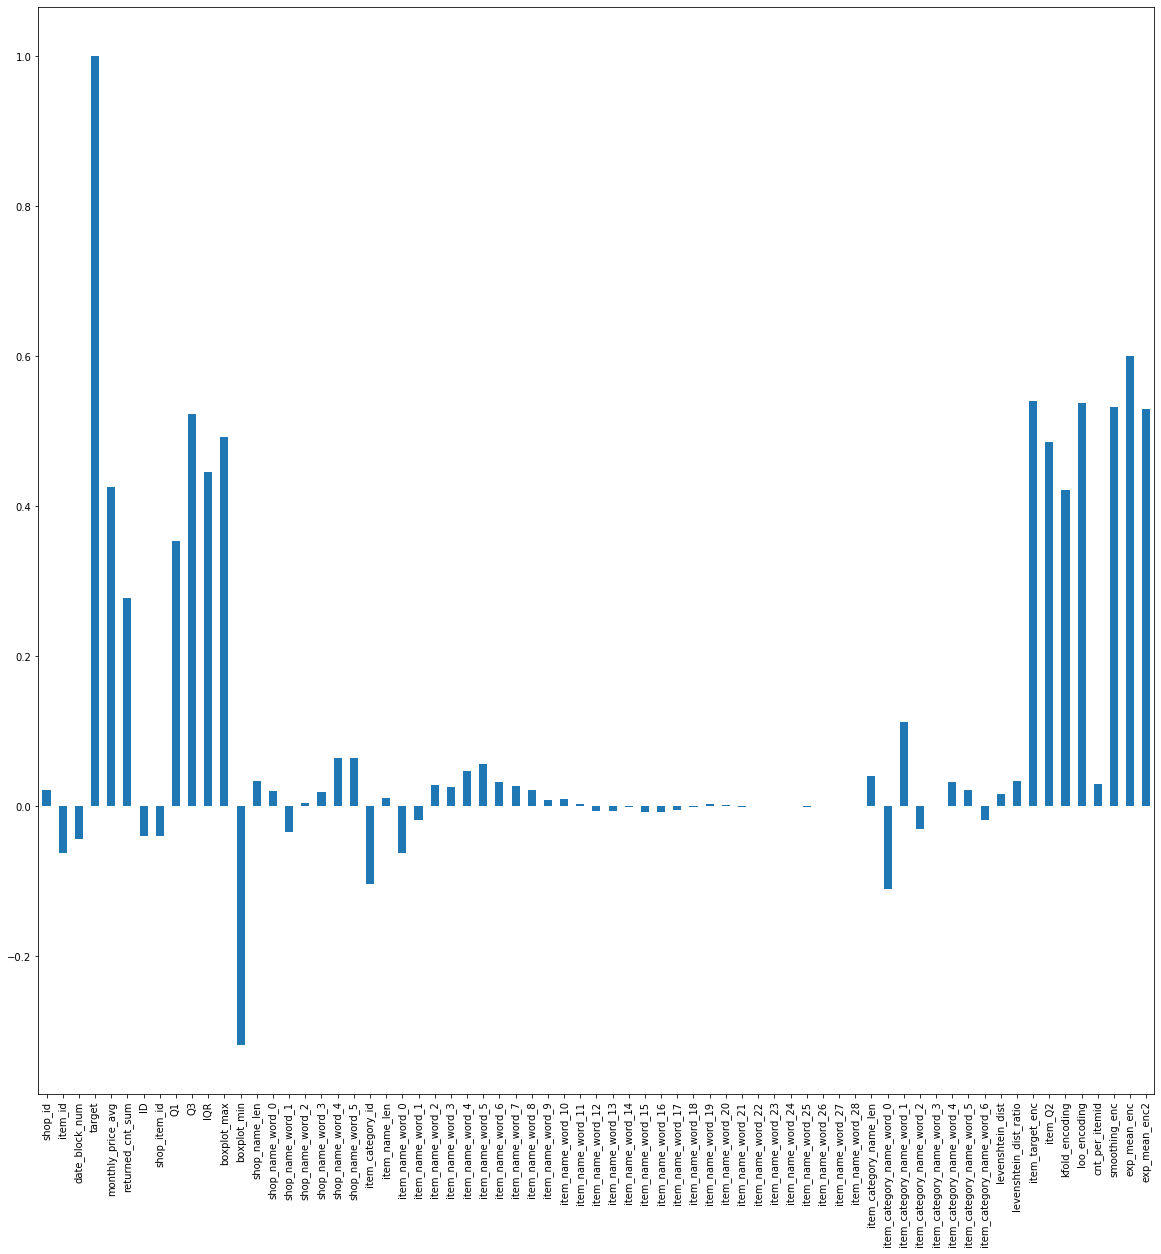

In [0]:

all_data.corr()['target'].plot(x='index', y='target', kind='bar', figsize=(20,20))

In [0]:
# we see that correlations are quite good with many feats. 
# especially those related to target (quantiles, encodings)
all_data.drop(columns=['item_name_word_' + str(i) for i in range(9, 29)], inplace=True)  # for such long words, majority of rows have an empty space
all_data.to_csv('/content/drive/My Drive/Colab Notebooks/FinalProject/all_data.csv', index=False)